## Programming assignment

Andrew id: pskadiya

### Import packages

In [28]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

import seaborn as sns
from matplotlib import pyplot as plt

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.linear_model import Lasso


import numpy as np


%matplotlib inline

### Data Setup and Processing

In [2]:
#read data
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
#checking dimensionality and sample size
df.shape

(545, 13)

In [4]:
#initial look at the data
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [5]:
object_columns = df.select_dtypes(include=['object']).columns

for col in object_columns:
    print(df[col].value_counts())
    print('\n')
    

yes    468
no      77
Name: mainroad, dtype: int64


no     448
yes     97
Name: guestroom, dtype: int64


no     354
yes    191
Name: basement, dtype: int64


no     520
yes     25
Name: hotwaterheating, dtype: int64


no     373
yes    172
Name: airconditioning, dtype: int64


no     417
yes    128
Name: prefarea, dtype: int64


semi-furnished    227
unfurnished       178
furnished         140
Name: furnishingstatus, dtype: int64




In [6]:
#checking for nulls
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

There are no nulls in the dataset, hence no dropping or additional processing is needed.

### Initial Visualizations

#### Integer variables

In [7]:
cont_columns = df.select_dtypes(include=['int64']).columns
cont_columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

<Axes: xlabel='parking', ylabel='Count'>

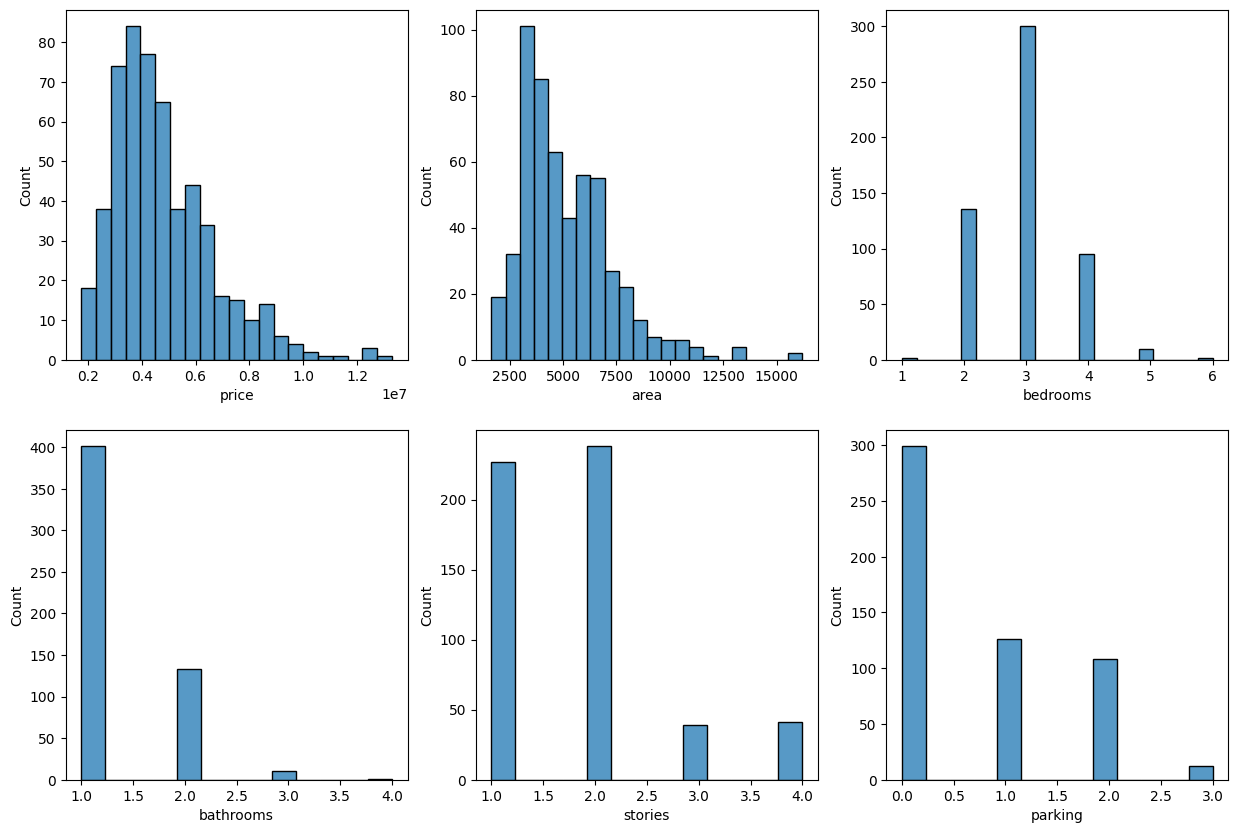

In [8]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

sns.histplot(data=df, x="price", ax=axes[0,0])
sns.histplot(data=df, x="area", ax=axes[0,1])
sns.histplot(data=df, x="bedrooms", ax=axes[0,2])
sns.histplot(data=df, x="bathrooms", ax=axes[1,0])
sns.histplot(data=df, x="stories", ax=axes[1,1])
sns.histplot(data=df, x="parking", ax=axes[1,2])

There aren't any obvious outliers. The data is slightly skewed (mostly to the left) however this shouldnt pose an issue for a prediction algorithm.

The target variable is 'price'.
All other variables will be features for the model.

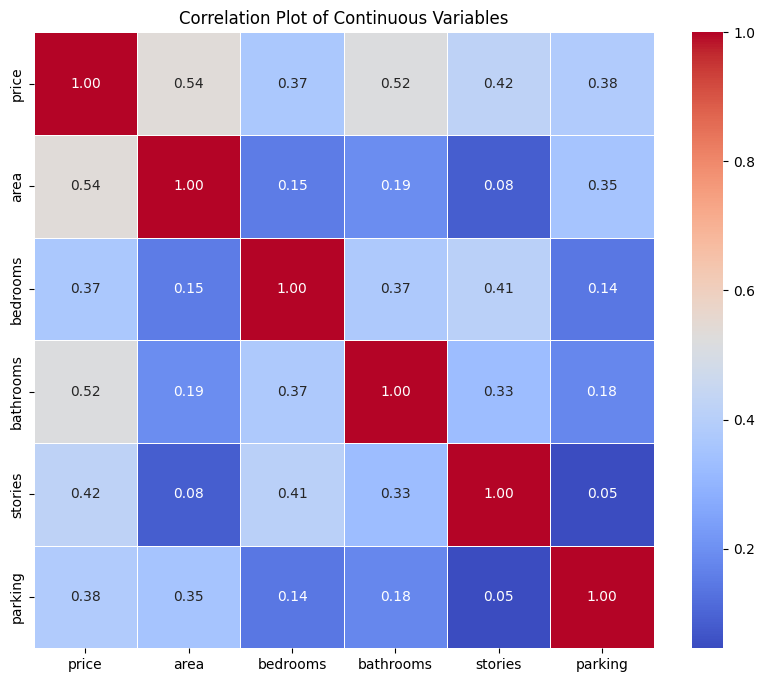

In [9]:
# correlation plot of continuous variables
cont_data = df[cont_columns]

# Calculate correlation matrix
corr_matrix = cont_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot of Continuous Variables')
plt.show()

### Feature Engineering

In [10]:
seed = 13

In [11]:
#encoding categorical, non-numerical variables
pd_dummy = pd.get_dummies(data=df[object_columns])
df = pd.concat([df,pd_dummy],axis=1).drop(columns=object_columns)


### Model Building

In [12]:
X = df[df.columns.difference(['price'])]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)


In [32]:
# Define the model hyperparameters
params = {"n_estimators": 50,  "max_depth": 25, "max_features": "sqrt", "random_state":seed }

# Train the model
rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# MAE as loss metric
mae = mean_absolute_error(y_test, y_pred)

In [33]:
X_test.shape

(164, 20)

In [34]:
X_train.shape

(381, 20)

### Define MLflow Experiment and Log - model, hyperparamters and loss metric

In [35]:
mlflow.set_experiment("House Price Prediction (PK)")

<Experiment: artifact_location='file:///Users/pranavakadiyala/OAI-lab1/mlruns/493125855766667732', creation_time=1708055699500, experiment_id='493125855766667732', last_update_time=1708055699500, lifecycle_stage='active', name='House Price Prediction (PK)', tags={}>

In [36]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("mean absolute error", mae)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random Forest model for house prediction data")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


/Users/pranavakadiyala/OAI-lab1/FOAI/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'house-prediction-model' already exists. Creating a new version of this model...
Created version '7' of model 'house-prediction-model'.


In [37]:
X_test.shape

(164, 20)

In [38]:
X_train.shape

(381, 20)

### View Model in MLflow

In [39]:
#!mlflow ui

In [40]:
X_test.shape

(164, 20)

### Model Evaluation

The model is evaluated using the Mean Absolute Error. 

### Model Comparision

For model comparision I compare the above random forest model with two other models:
1. The model chosen as part of the Kaggle Zillow Competition is: (unfortunately I couldn't find the model details of the winner)
"ls = Lasso(alpha=1e-6, normalize=True)"
Link: https://www.kaggle.com/code/flennerhag/ml-ensemble-scikit-learn-style-ensemble-learning

2. From the GitHUb repository I use the XGBoost regressor model:
    "xgb_regressor_model = XGBRegressor(n_estimators=900,
                                   learning_rate=0.04,
                                   random_state=seed,
                                   n_jobs=4)"
   This model is from: https://github.com/vaibhavvikas/housing-price-predictor/tree/main

#### Lasso Model

In [41]:
# Train the model
params_lasso = {"alpha": 1e-6, "normalize":True, "random_state":seed}
ls = Lasso(**params_lasso)
ls.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = ls.predict(X_test)

# MAE as loss metric
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

/Users/pranavakadiyala/OAI-lab1/FOAI/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [42]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_lasso)

    # Log the loss metric
    mlflow.log_metric("mean absolute error", mae_lasso)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "lasso model for house prediction data")

    # Infer the model signature
    signature = infer_signature(X_train, ls.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=ls,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


/Users/pranavakadiyala/OAI-lab1/FOAI/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'house-prediction-model' already exists. Creating a new version of this model...
Created version '8' of model 'house-prediction-model'.


In [43]:
#!mlflow ui

#### XGBoost Model

In [44]:
params_xgb = {"n_estimators":900, "learning_rate":0.04, "random_state":seed, "n_jobs":4}
xgb = XGBRegressor(**params_xgb)
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb.predict(X_test)

# MAE as loss metric
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

In [45]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_xgb)

    # Log the loss metric
    mlflow.log_metric("mean absolute error", mae_xgb)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "XGBoost model for house prediction data")

    # Infer the model signature
    signature = infer_signature(X_train, xgb.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=xgb,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


/Users/pranavakadiyala/OAI-lab1/FOAI/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'house-prediction-model' already exists. Creating a new version of this model...
Created version '9' of model 'house-prediction-model'.


In [ ]:
!mlflow ui

[2024-02-16 21:41:55 -0500] [16839] [INFO] Starting gunicorn 21.2.0
[2024-02-16 21:41:55 -0500] [16839] [INFO] Listening at: http://127.0.0.1:5000 (16839)
[2024-02-16 21:41:55 -0500] [16839] [INFO] Using worker: sync
[2024-02-16 21:41:55 -0500] [16840] [INFO] Booting worker with pid: 16840
[2024-02-16 21:41:55 -0500] [16841] [INFO] Booting worker with pid: 16841
[2024-02-16 21:41:55 -0500] [16842] [INFO] Booting worker with pid: 16842
[2024-02-16 21:41:55 -0500] [16843] [INFO] Booting worker with pid: 16843
[2024-02-16 22:00:19 -0500] [16839] [CRITICAL] WORKER TIMEOUT (pid:16840)
[2024-02-16 22:00:19 -0500] [16839] [CRITICAL] WORKER TIMEOUT (pid:16841)
[2024-02-16 22:00:19 -0500] [16839] [CRITICAL] WORKER TIMEOUT (pid:16842)
[2024-02-16 22:00:19 -0500] [16839] [CRITICAL] WORKER TIMEOUT (pid:16843)
[2024-02-16 22:00:19 -0500] [16840] [INFO] Worker exiting (pid: 16840)
[2024-02-16 22:00:19 -0500] [16842] [INFO] Worker exiting (pid: 16842)
[2024-02-16 22:00:19 -0500] [16841] [INFO] Worker

**Looking at the models and evaluating on the basis of MAE - the best model is Lasso with these parameters:
"alpha": 1e-6, "normalize":True
This model was chosen as part of the Zillow Kaggle Competition.**

### Model Serving

In [50]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [51]:
predictions = loaded_model.predict(X_test)

# Convert X_test validation feature data to a Pandas DataFrame
result = pd.DataFrame(X_test, columns=X_test.columns)

# Add the actual classes to the DataFrame
result["actual_class"] = y_test

# Add the model predictions to the DataFrame
result["predicted_class"] = predictions

result[:4]

,airconditioning_no,airconditioning_yes,area,basement_no,basement_yes,bathrooms,bedrooms,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,hotwaterheating_no,hotwaterheating_yes,mainroad_no,mainroad_yes,parking,prefarea_no,prefarea_yes,stories,actual_class,predicted_class
0,0,1,7420,1,0,2,4,1,0,0,...,1,0,0,1,2,0,1,3,13300000,8844222.00
118,0,1,6420,0,1,1,3,1,0,0,...,1,0,0,1,0,0,1,1,5950000,6288735.00
200,0,1,4520,0,1,1,3,0,1,0,...,1,0,0,1,0,1,0,2,4900000,4054742.25
323,1,0,5400,1,0,1,3,0,1,0,...,1,0,0,1,3,1,0,1,4025000,5060902.50
